# Transfer learning using MobileNetV2

## Transfer learning involves using a pre-trained model and then modifying the final layer to have the correct number of classes.
## This is a good way to save time and improve the accuracy of the model.

## Steps are as follows:
#### 1. Load the pre-trained model
### 2. Modify the final layer to have the correct number of classes
### 3. Train the model on the new dataset
### 4. Save the model

In [1]:
# import the necessary libraries to perform the above steps using pytorch
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split, ConcatDataset
from torchvision import transforms, models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import numpy as np
import os
import json
import random
import csv

def setup_environment():
    try:
        # Check if running in Google Colab
        import google.colab
        print("Running in Google Colab.")

        # Mount Google Drive
        from google.colab import drive
        drive.mount('/content/drive')

        # Set the file path for Google Drive
        file_path = '/content/drive/My Drive/hand_gesture'
        training_data_path = f'{file_path}/unified_dataset'
    except ImportError:
        # Local environment
        print("Running in local environment.")

        # Check for CUDA (NVIDIA GPU)
        if torch.cuda.is_available():
            print("CUDA GPU detected!")
            gpu_name = torch.cuda.get_device_name(0)  # Get name of the first CUDA GPU
            print(f"Using GPU: {gpu_name}")

        # Check for Apple GPU (Metal support)
        elif torch.backends.mps.is_available():
            print("Apple GPU detected with Metal support!")
            # ensure that Mac M1 GPU is being used
            device = torch.device("mps")

        # No GPU detected
        else:
            print("No GPU detected. Running on CPU.")

        # Set the local file path
        file_path = '/Users/fergusproctor/Library/CloudStorage/GoogleDrive-100554681@alumnos.uc3m.es/My Drive/hand_gesture'

        #'/Users/fergusproctor/dev/archive/asl_alphabet_train/asl_alphabet_train'
        training_data_path = '/Users/fergusproctor/dev/unified_dataset'

    print(f"Using file path: {file_path}")
    return file_path, training_data_path, device

# Use the function
file_path, training_data_path, device = setup_environment()

# testing writing commit back to google colab

/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/bin/.

Running in local environment.
Apple GPU detected with Metal support!
Using file path: /Users/fergusproctor/Library/CloudStorage/GoogleDrive-100554681@alumnos.uc3m.es/My Drive/hand_gesture


In [2]:

# load the pre-trained model
model = models.efficientnet_b0(pretrained=True)

# print the model architecture

/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# save path to training data at /Users/fergusproctor/Library/CloudStorage/OneDrive-Personal/Documents/Robotics Masters/Vision por Computadora/Proyecto Vision/Proyecto Vision-Fergus’s MacBook Air



train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225]))
])

# Load the full training dataset
full_training_data = datasets.ImageFolder(root=training_data_path,
    transform=train_transforms)

# Get a list of all classes
classes = full_training_data.classes
num_classes = len(full_training_data.classes)
print(f"Number of classes: {num_classes}")

# turn training dataset into 10% of the original dataset
# for testing purposes [OPTIONAL]
# full_training_data = Subset(full_training_data, range(0, int(len(full_training_data)/10)))

# Calculate the number of samples for the test set (10% of the total data)
test_size = int(0.1 * len(full_training_data))  # 10% of the dataset
train_size = len(full_training_data) - 2 * test_size  # 80% for training, 10% for validation, 10% for test

# Split the data into training, validation, and test sets
train_data, val_data, test_data = random_split(full_training_data, [train_size, test_size, test_size])

# Save the split indices so training, validation, and test datasets can be reproduced later
with open('train_indices.json', 'w') as f:
    json.dump(train_data.indices, f)

with open('val_indices.json', 'w') as f:
    json.dump(val_data.indices, f)

with open('test_indices.json', 'w') as f:
    json.dump(test_data.indices, f)

# Create DataLoaders for training, validation, and test datasets
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Print the number of images in the training, validation, and test sets
print(f"Number of images in the training set: {len(train_data)}")
print(f"Number of images in the validation set: {len(val_data)}")
print(f"Number of images in the test set: {len(test_data)}")


Number of classes: 29
Number of images in the training set: 78405
Number of images in the validation set: 9800
Number of images in the test set: 9800


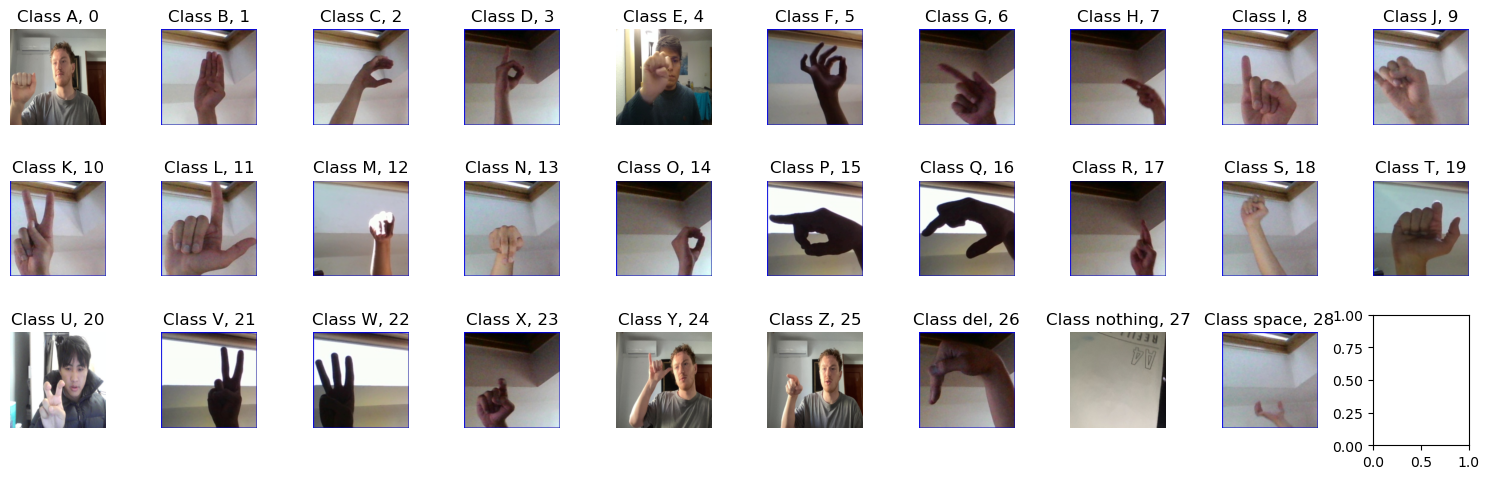

In [4]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
axes = axes.ravel()

# For each class
for idx, class_name in enumerate(classes):
    # Get indices of all images in this class
    class_indices = [i for i, (_, label) in enumerate(full_training_data.samples) if label == idx]

    # Randomly select one image from this class
    random_idx = random.choice(class_indices)
    img, _ = full_training_data[random_idx]

    # Convert tensor to numpy array and transpose to correct dimensions
    img = img.permute(1, 2, 0).numpy()

    # Denormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean

    # Clip values to be between 0 and 1
    img = np.clip(img, 0, 1)

    # Plot the image
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Class {class_name}, {idx}')

plt.tight_layout()
plt.show()


In [5]:
# update the final layer of the model to have the correct number of classes, which is the
# number of classes in the training data
print(num_classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# print the model architecture
print(model)

29
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActi

In [6]:

print("Using device:", device)

Using device: mps


In [7]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
# Freeze all layers except the classifier
for param in model.features.parameters():
    param.requires_grad = False

# Verify only classifier is trainable
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

model = model.to(device)

print(device)

# Number of epochs
num_epochs = 10

# create training history json file
training_history = {
    "epoch": [],
    "loss": [],
    "accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:  # training_data is your DataLoader
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_data)}")

    # Save the loss to the training history
    training_history["epoch"].append(epoch)
    training_history["loss"].append(running_loss / len(train_data))
    training_history["accuracy"].append(0)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            # Forward pass
            val_outputs = model(val_inputs)

            # Compute the loss
            val_loss += criterion(val_outputs, val_labels).item()

            # Compute the accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss /= len(val_data)
    val_accuracy = 100 * val_correct / val_total

    # Print validation loss and accuracy
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%")

    # Save validation loss and accuracy to the training history
    training_history["val_loss"].append(val_loss)
    training_history["val_accuracy"].append(val_accuracy)
    print(training_history["val_loss"])

mps
Epoch 1/10, Loss: 0.050425951733712934
Validation Loss: 0.04763688009612414, Validation Accuracy: 40.97959183673469%
[0.04763688009612414]
Epoch 2/10, Loss: 0.045931398046768546
Validation Loss: 0.043019041552835584, Validation Accuracy: 58.96938775510204%
[0.04763688009612414, 0.043019041552835584]
Epoch 3/10, Loss: 0.04211219924193059
Validation Loss: 0.03901622713828574, Validation Accuracy: 65.66326530612245%
[0.04763688009612414, 0.043019041552835584, 0.03901622713828574]
Epoch 4/10, Loss: 0.0388099039766331
Validation Loss: 0.03574159344848321, Validation Accuracy: 69.10204081632654%
[0.04763688009612414, 0.043019041552835584, 0.03901622713828574, 0.03574159344848321]
Epoch 5/10, Loss: 0.03603124941165453
Validation Loss: 0.033484256048591766, Validation Accuracy: 70.9795918367347%
[0.04763688009612414, 0.043019041552835584, 0.03901622713828574, 0.03574159344848321, 0.033484256048591766]
Epoch 6/10, Loss: 0.03366715370578643
Validation Loss: 0.03076251325558643, Validation Ac

In [14]:
print(training_history["epoch"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [13]:
# Save the model's state dictionary
model_instance_name = 'entire_dataset_effnet_b0'
torch.save(model.state_dict(), f'../{model_instance_name}.pth')

# Save training history to JSON
json_file_path = "training_history.json"
with open(json_file_path, "w") as json_file:
    json.dump(training_history, json_file)
print(f"Training history saved to {json_file_path}")

# Save training history to CSV
csv_file_path = f"training_history_{model_instance_name}.csv"
with open(csv_file_path, "w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    # Write header
    writer.writerow(["epoch", "loss", "accuracy", "val_loss", "val_accuracy"])
    # Write data
    for i in range(len(training_history["epoch"])):
        writer.writerow([
            training_history["epoch"][i],
            training_history["loss"][i],
            training_history["accuracy"][i],
            training_history["val_loss"][i],
            training_history["val_accuracy"][i]
        ])
print(f"Training history saved to {csv_file_path}")

print("Model saved successfully!")


Training history saved to training_history.json
Training history saved to training_history_entire_dataset_effnet_b0.csv
Model saved successfully!


# Model evaluation

In [16]:
# Instantiate the model (same architecture as before)
model = models.efficientnet_b0(pretrained=False)


# If you made changes to the model, apply them (e.g., modifying the classifier)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 29)

#model_instance_name = "mobilenet_sign_w_user_data_10_ep.pth"

# Load the saved model weights
model.load_state_dict(torch.load(f'../entire_dataset_effnet_b0.pth'))
model = model.to(device)


# Set the model to evaluation mode for inference
model.eval()

print("Model loaded successfully! Model set to evaluation mode")

# Evaluate the model on the test set
# save path to training data at /Users/fergusproctor/Library/CloudStorage/OneDrive-Personal/Documents/Robotics Masters/Vision por Computadora/Proyecto Vision/Proyecto Vision-Fergus’s MacBook Air
training_data_path = "/Users/fergusproctor/dev/unified_dataset"
#training_data_path = '/Users/fergusproctor/dev/archive/asl_alphabet_train/asl_alphabet_train'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225]))
])

# Load the full training dataset
full_training_data = datasets.ImageFolder(root=training_data_path,
    transform=train_transforms)

# randomly split out 10% of the data for testing
test_size = int(0.1 * len(full_training_data))
train_size = len(full_training_data) - 2 * test_size

train_data, val_data, test_data = random_split(full_training_data, [train_size, test_size, test_size])

# access the test set using test indices
#with open('test_indices.json', 'r') as f:
#    test_indices = json.load(f)



## Create a Subset from the test indices
#test_data = Subset(full_training_data, test_indices)


# Create a DataLoader for the test set
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Number of images in the test set: {len(test_data)}")

/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/dv/3vlkd_t53j9gr9ggfhz4wg2w0000gn/T/ipykernel_77838/1530149348.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#un

Model loaded successfully! Model set to evaluation mode
Number of images in the test set: 9800


In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Test Loss: 1.5455
Test Accuracy: 0.7727

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       337
           1       0.77      0.88      0.82       351
           2       0.82      0.82      0.82       359
           3       0.94      0.83      0.89       345
           4       0.63      0.80      0.70       323
           5       0.77      0.88      0.82       345
           6       0.80      0.85      0.82       395
           7       0.87      0.83      0.85       349
           8       0.75      0.81      0.78       330
           9       0.75      0.76      0.75       336
          10       0.79      0.80      0.79       339
          11       0.83      0.88      0.86       357
          12       0.77      0.74      0.76       325
          13       0.72      0.77      0.74       360
          14       0.70      0.86      0.77       304
          15       0.81      0.79      0.80       333
          16     

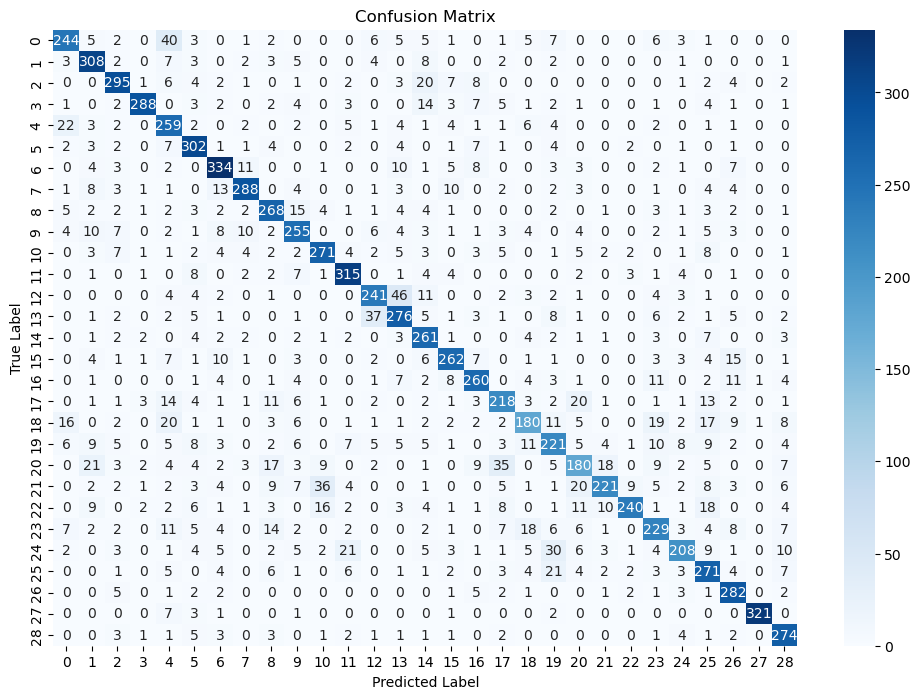

In [18]:


# Initialize lists to store predictions and actual labels
predictions = []
actual_labels = []
running_test_loss = 0.0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and labels
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predictions)
print(f"Test Loss: {running_test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(actual_labels, predictions))

# Create confusion matrix
cm = confusion_matrix(actual_labels, predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# save classification report to a csv file
import pandas as pd
metrics_df = pd.DataFrame(classification_report(actual_labels, predictions, output_dict=True)).transpose()
metrics_df.to_csv(f'{model_instance_name}_classification_metrics.csv')


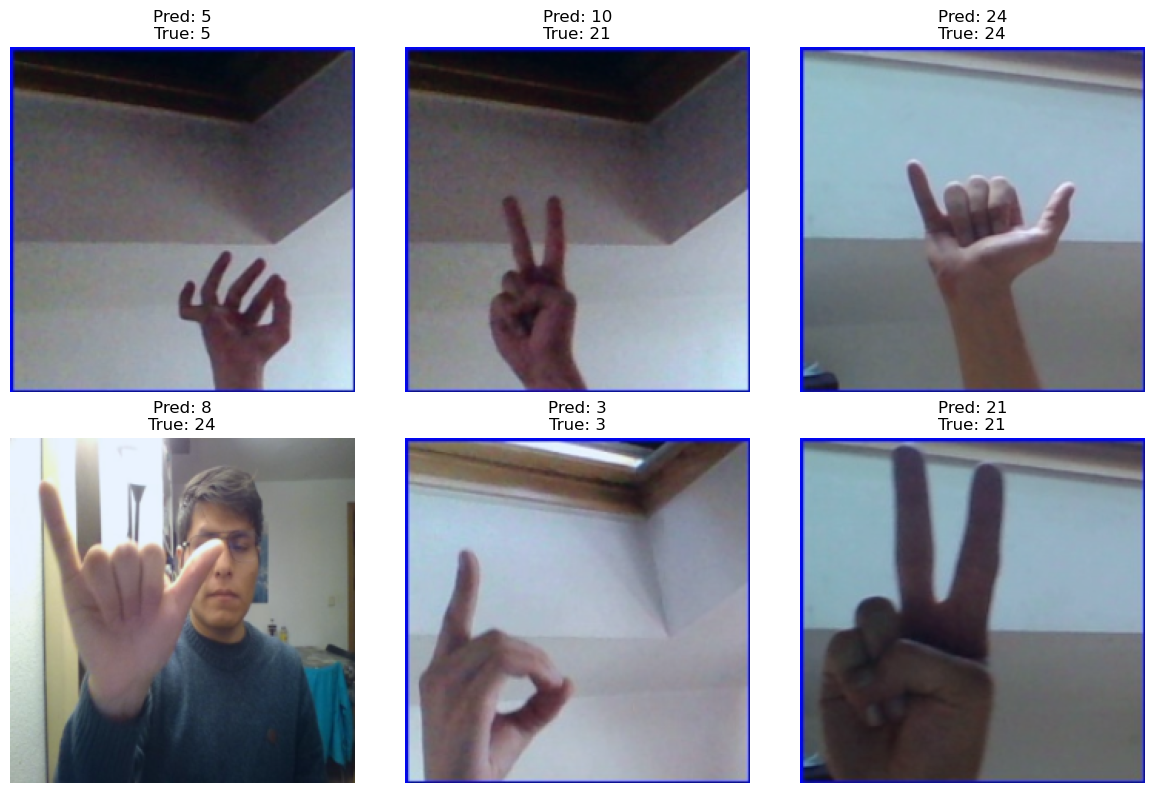

In [19]:
# show test images, predictions and true classes alongside each other
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs.data, 1)

# Convert tensors to numpy arrays
images = images.cpu().numpy()
predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

# Plot 6 images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx in range(6):
    # Get the image and normalize it
    img = np.transpose(images[idx], (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())

    # Plot image
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Pred: {predicted[idx]}\nTrue: {labels[idx]}')

plt.tight_layout()
plt.show()